<a href="https://colab.research.google.com/github/rohskopf/FitSNAP/blob/custom-networks/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The FitSNAP-LAMMPS ecosystem for constructing & deconstructing potentials


*   We will keep this Colab notebook updated as the code changes. Please refer to it for future use.
*   We have GPU access on Colab, but it is unreliable for PyTorch (at least the way we set things up in this tutorial).

# Setup environment

In [ ]:
!which python
!python --version

/usr/local/bin/python
Python 3.7.14


In [1]:
!apt install -y cmake build-essential git ccache openmpi-bin libopenmpi-dev python3.7-venv

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
libopenmpi-dev is already the newest version (2.1.1-8).
openmpi-bin is already the newest version (2.1.1-8).
openmpi-bin set to manually installed.
cmake is already the newest version (3.10.2-1ubuntu2.18.04.2).
git is already the newest version (1:2.17.1-1ubuntu0.12).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  distcc
The following NEW packages will be installed:
  ccache python3.7-venv
0 upgraded, 2 newly installed, 0 to remove and 12 not upgraded.
Need to get 2,626 kB of archives.
After this operation, 3,059 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 ccache amd64 3.4.1-1 [110 kB]
Get:2 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic/main amd64 python3.7-venv

In [2]:
pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 2.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [38]:
pip install numpy torch scipy virtualenv psutil pandas tabulate mpi4py Cython sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=e0483e29313adb77fb36a1cb51d9f56e8d40254f5eb6bd7067376cf8b6a928e4
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [4]:
from mpi4py import MPI

Get LAMMPS and install LAMMPS-Python interface.

In [5]:
#!apt install -y cmake build-essential git ccache openmpi-bin libopenmpi-dev python3.7-venv
#!apt install -y cmake build-essential git ccache python3.7-venv
%cd /content
!rm -rf lammps
!git clone https://github.com/lammps/lammps.git lammps
%cd /content/lammps
!rm -rf build
!mkdir build
%cd build
!cmake ../cmake -DLAMMPS_EXCEPTIONS=yes \
               -DBUILD_SHARED_LIBS=yes \
               -DMLIAP_ENABLE_PYTHON=yes \
               -DPKG_PYTHON=yes \
               -DPKG_ML-SNAP=yes \
               -DPKG_ML-IAP=yes \
               -DPKG_ML-PACE=yes \
               -DPKG_SPIN=yes \
               -DPYTHON_EXECUTABLE:FILEPATH=`which python`
!make -j 2
!make install-python

/content
Cloning into 'lammps'...
remote: Enumerating objects: 328573, done.
remote: Counting objects: 100% (1750/1750), done.
remote: Compressing objects: 100% (633/633), done.
remote: Total 328573 (delta 1166), reused 1668 (delta 1115), pack-reused 326823
Receiving objects: 100% (328573/328573), 600.77 MiB | 22.89 MiB/s, done.
Resolving deltas: 100% (275821/275821), done.
Checking out files: 100% (11942/11942), done.
/content/lammps
/content/lammps/build
-- The CXX compiler identification is GNU 7.5.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found Git: /usr/bin/git (found version "2.17.1") 
-- Appending /usr/local/cuda/lib64/stubs to CMAKE_LIBRARY_PATH: /usr/local/cuda/lib64/stubs
-- Running check for auto-generated files from make-based build system
-- Found MPI_CXX: /usr/lib/x86_64-linux-gnu/openmpi/lib/libmpi_cx

Check if Python-LAMMPS is working:

In [6]:
import lammps
lmp = lammps.lammps()
print(lmp)

If no errors, we're good to!

# Get FitSNAP

In [41]:
%cd /content
!rm -rf FitSNAP
!git clone -b custom-networks https://github.com/rohskopf/FitSNAP #https://github.com/FitSNAP/FitSNAP
# Set environment variables
!$PYTHONPATH
%env PYTHONPATH=/env/python:/bin/bash:/content/FitSNAP
%env LD_LIBRARY_PATH=/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/lammps/build
!cp -r FitSNAP/fitsnap3lib /usr/lib/python3.7/fitsnap3lib

/content
Cloning into 'FitSNAP'...
remote: Enumerating objects: 35768, done.
remote: Counting objects: 100% (2727/2727), done.
remote: Compressing objects: 100% (1052/1052), done.
remote: Total 35768 (delta 1717), reused 2561 (delta 1642), pack-reused 33041
Receiving objects: 100% (35768/35768), 214.96 MiB | 22.17 MiB/s, done.
Resolving deltas: 100% (15358/15358), done.
Checking out files: 100% (30589/30589), done.
/bin/bash: /env/python:/bin/bash:/content/FitSNAP: No such file or directory
env: PYTHONPATH=/env/python:/bin/bash:/content/FitSNAP
env: LD_LIBRARY_PATH=/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/lammps/build


In [ ]:
!/usr/lib/python3.7/fitsnap3lib

/bin/bash: /usr/lib/python3.7/fitsnap3lib: Is a directory


### Stay updated with the newest version

In [44]:
%cd /content/FitSNAP
!git fetch
!git pull
#!git reset --hard origin/custom-networks
!rm -rf /usr/lib/python3.7/fitsnap3lib
!cp -rf fitsnap3lib /usr/lib/python3.7/fitsnap3lib

/content/FitSNAP
Already up to date.


# Linear SNAP for tantalum



*   We start with running FitSNAP as an executable. 
*   The general command is `mpirun -np P python -m fitsnap3 input.in`
*   We will do serial execution in this tutorial because `mpirun` is buggy on Colab.



In [12]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014
!python -m fitsnap3 Ta-example.in --overwrite

/content/FitSNAP/examples/Ta_Linear_JCP2014

    ______ _  __  _____  _   __ ___     ____  
   / ____/(_)/ /_/ ___/ / | / //   |   / __ \ 
  / /_   / // __/\__ \ /  |/ // /| |  / /_/ /
 / __/  / // /_ ___/ // /|  // ___ | / ____/ 
/_/    /_/ \__//____//_/ |_//_/  |_|/_/      

-----23Sep22------
Reading input...
Finished reading input
------------------
mpi4py version:  3.1.3
numpy version:  1.21.6
scipy version:  1.7.3
pandas version:  1.3.5
LAMMPS (15 Sep 2022)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
-----------
Total wall time: 0:00:00
Using LAMMPSSNAP as FitSNAP calculator
Displaced_A15 : Detected  9  fitting on  9  testing on  0
Displaced_BCC : Detected  9  fitting on  9  testing on  0
Displaced_FCC : Detected  9  fitting on  9  testing on  0
Elastic_BCC : Detected  100  fitting on  100  testing on  0
Elastic_FCC : Detected  100  fitting on  100  testing on  0
GSF_110 : Detected  22  fitting on  22  

Look at the output

In [13]:
!ls

20May21_Standard      FitSNAP.df  Ta-example.in		Ta_pot.snapparam
anl		      JSON	  Ta-example-nodump.in	Test_Set_Example
compare_snapcoeff.py  log.lammps  Ta_metrics.md		Truth-Ref.npy
Descriptors.npy       README.md   Ta_pot.snapcoeff	Weights.npy


Linear models output a Pandas dataframe `FitSNAP.df`, which has information about the fit. 

Errors are included in `Ta_metrics.md` for each group, but we can also use the FitSNAP library to help us process/analyze the dataframe.


In [14]:
# Import FitSNAP library tools for dataframe analysis
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014 
from fitsnap3lib.tools.dataframe_tools import DataframeTools
from fitsnap3lib.io.input import Config
config = Config(arguments_lst = ["Ta-example.in", "--overwrite"])

/content/FitSNAP/examples/Ta_Linear_JCP2014


Let's look at what's in the dataframe:

*   First 31 columns are the SNAP bispectrum components used in the fitting matrix.
*   `truths` are the target values (e.g. energy, force, stress)
*   `preds` are the model values
*   `weights` are the user-defined weighting factors
*   `Groups` designate which user-defined group this row belongs to
*   `Configs` are the filenames associated with particular rows
*   `Row_Type` tells which rows are `Energy`, `Force`, or `Stress` rows
*   `Atom_I` is the atom index associated with a row
*   `Testing` are bools designating which rows are used for testing (not training)
*   `Atom_Type` designate which `Force` rows belong to a certain atom type



In [15]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

dataframe_tool = DataframeTools("FitSNAP.df")
df = dataframe_tool.read_dataframe()
df

,0,1,2,3,4,5,6,7,8,9,...,30,truths,preds,weights,Groups,Configs,Row_Type,Atom_I,Testing,Atom_Type
0,1.0,1.009033e+02,2.780691e+00,0.635714,8.179305e+00,-2.940313,1.045951,1.264225e+00,6.488682e+01,-2.653318e+00,...,18.753597,-16.595362,-1.659676e+01,1.000000e+02,Displaced_A15,A15_3.json,Energy,0,False,0
1,0.0,4.627919e+00,8.129999e-01,-0.232867,1.287718e+00,-0.139467,0.035210,6.649557e-02,-3.313145e+00,2.725776e-01,...,-3.676965,-0.300870,-4.361515e-01,1.000000e+00,Displaced_A15,A15_3.json,Force,0,False,1
2,0.0,-7.121813e-01,6.199341e-01,-0.837443,2.850890e+00,0.963122,-0.443889,8.972694e-01,-1.814308e+01,2.669129e+00,...,-4.574918,-0.802728,-6.584778e-01,1.000000e+00,Displaced_A15,A15_3.json,Force,0,False,1
3,0.0,-1.093067e+00,-7.484353e-01,0.144245,1.758252e+00,0.033253,0.452872,2.874145e-01,-6.299933e+00,-1.015037e+00,...,1.244826,0.046724,1.908140e-01,1.000000e+00,Displaced_A15,A15_3.json,Force,0,False,1
4,0.0,-2.880540e+00,-4.767350e-01,0.815266,-5.128569e+00,-0.935406,-0.141302,-1.044284e+00,2.733340e+01,-2.519177e+00,...,6.774157,0.909071,9.077672e-01,1.000000e+00,Displaced_A15,A15_3.json,Force,1,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15208,0.0,1.009043e+06,-1.400173e+05,-190120.257627,1.255084e+06,-258886.737857,686570.429085,1.045321e+05,2.639749e+05,-3.035289e+05,...,-789841.810903,-331591.046038,-7.783657e+04,1.000000e-09,Volume_FCC,FCC_5.5.json,Stress,0,False,0
15209,0.0,1.009043e+06,-1.400173e+05,-190120.257627,1.255084e+06,-258886.737857,686570.429085,1.045321e+05,2.639749e+05,-3.035289e+05,...,-789841.810903,-331591.046038,-7.783657e+04,1.000000e-09,Volume_FCC,FCC_5.5.json,Stress,0,False,0
15210,0.0,0.000000e+00,0.000000e+00,0.000000,-3.421232e-11,0.000000,0.000000,0.000000e+00,7.483945e-12,-1.282962e-11,...,0.000000,0.000000,3.627234e-12,1.000000e-09,Volume_FCC,FCC_5.5.json,Stress,0,False,0
15211,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,1.282962e-11,-4.276540e-12,...,0.000000,0.000000,-3.446098e-12,1.000000e-09,Volume_FCC,FCC_5.5.json,Stress,0,False,0


In [16]:
mae_energy_total = dataframe_tool.calc_error("Energy", "Training")
mae_force_total = dataframe_tool.calc_error("Force", "Training")
print(f"{mae_energy_total} {mae_force_total}")

0.11278674722617991 0.07575757670459787


In [17]:
mae_energy = dataframe_tool.calc_error("Energy", "Training", "Volume_BCC")
mae_force = dataframe_tool.calc_error("Force", "Training", "Volume_BCC")
print(f"{mae_energy} {mae_force}")

0.3285981181749077 3.856080502920244e-15


In [18]:
print(f"{'Group':15} {'Energy MAE':3} {'Force MAE':3}")
for group in config.sections['GROUPS'].group_table:
    mae_energy_group = dataframe_tool.calc_error("Energy", "Training", group)
    mae_force_group = dataframe_tool.calc_error("Force", "Training", group)
    print(f"{group:15} {mae_energy_group:.3e} {mae_force_group:.3e}")

Group           Energy MAE Force MAE
Displaced_A15   2.358e-03 9.806e-02
Displaced_BCC   1.884e-03 1.434e-01
Displaced_FCC   6.167e-04 5.741e-02
Elastic_BCC     6.411e-03 7.272e-05
Elastic_FCC     3.618e-03 9.642e-05
GSF_110         6.524e-03 2.650e-02
GSF_112         8.684e-03 5.698e-02
Liquid          5.668e-03 3.538e-01
Surface         1.352e-02 4.760e-02
Volume_A15      2.458e-01 4.645e-15
Volume_BCC      3.286e-01 3.856e-15
Volume_FCC      8.121e-01 3.256e-15


FitSNAP library has built-in tools for plotting dataframe quantities.

`dataframe_tools.plot_agreement(quantity="Energy", fitting_set="Training", legend=True, mode="Distribution")`

Sometimes it's useful to plot the data to see what the outliers are.

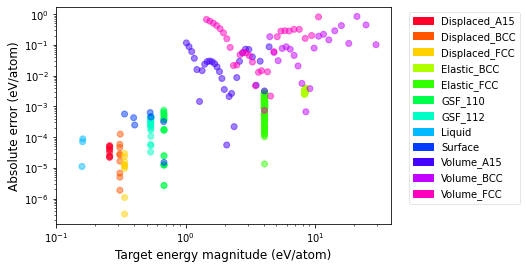

In [20]:
dataframe_tool.plot_agreement("Energy", fitting_set="Training", mode="Distribution")

Better way to view images in Colab:

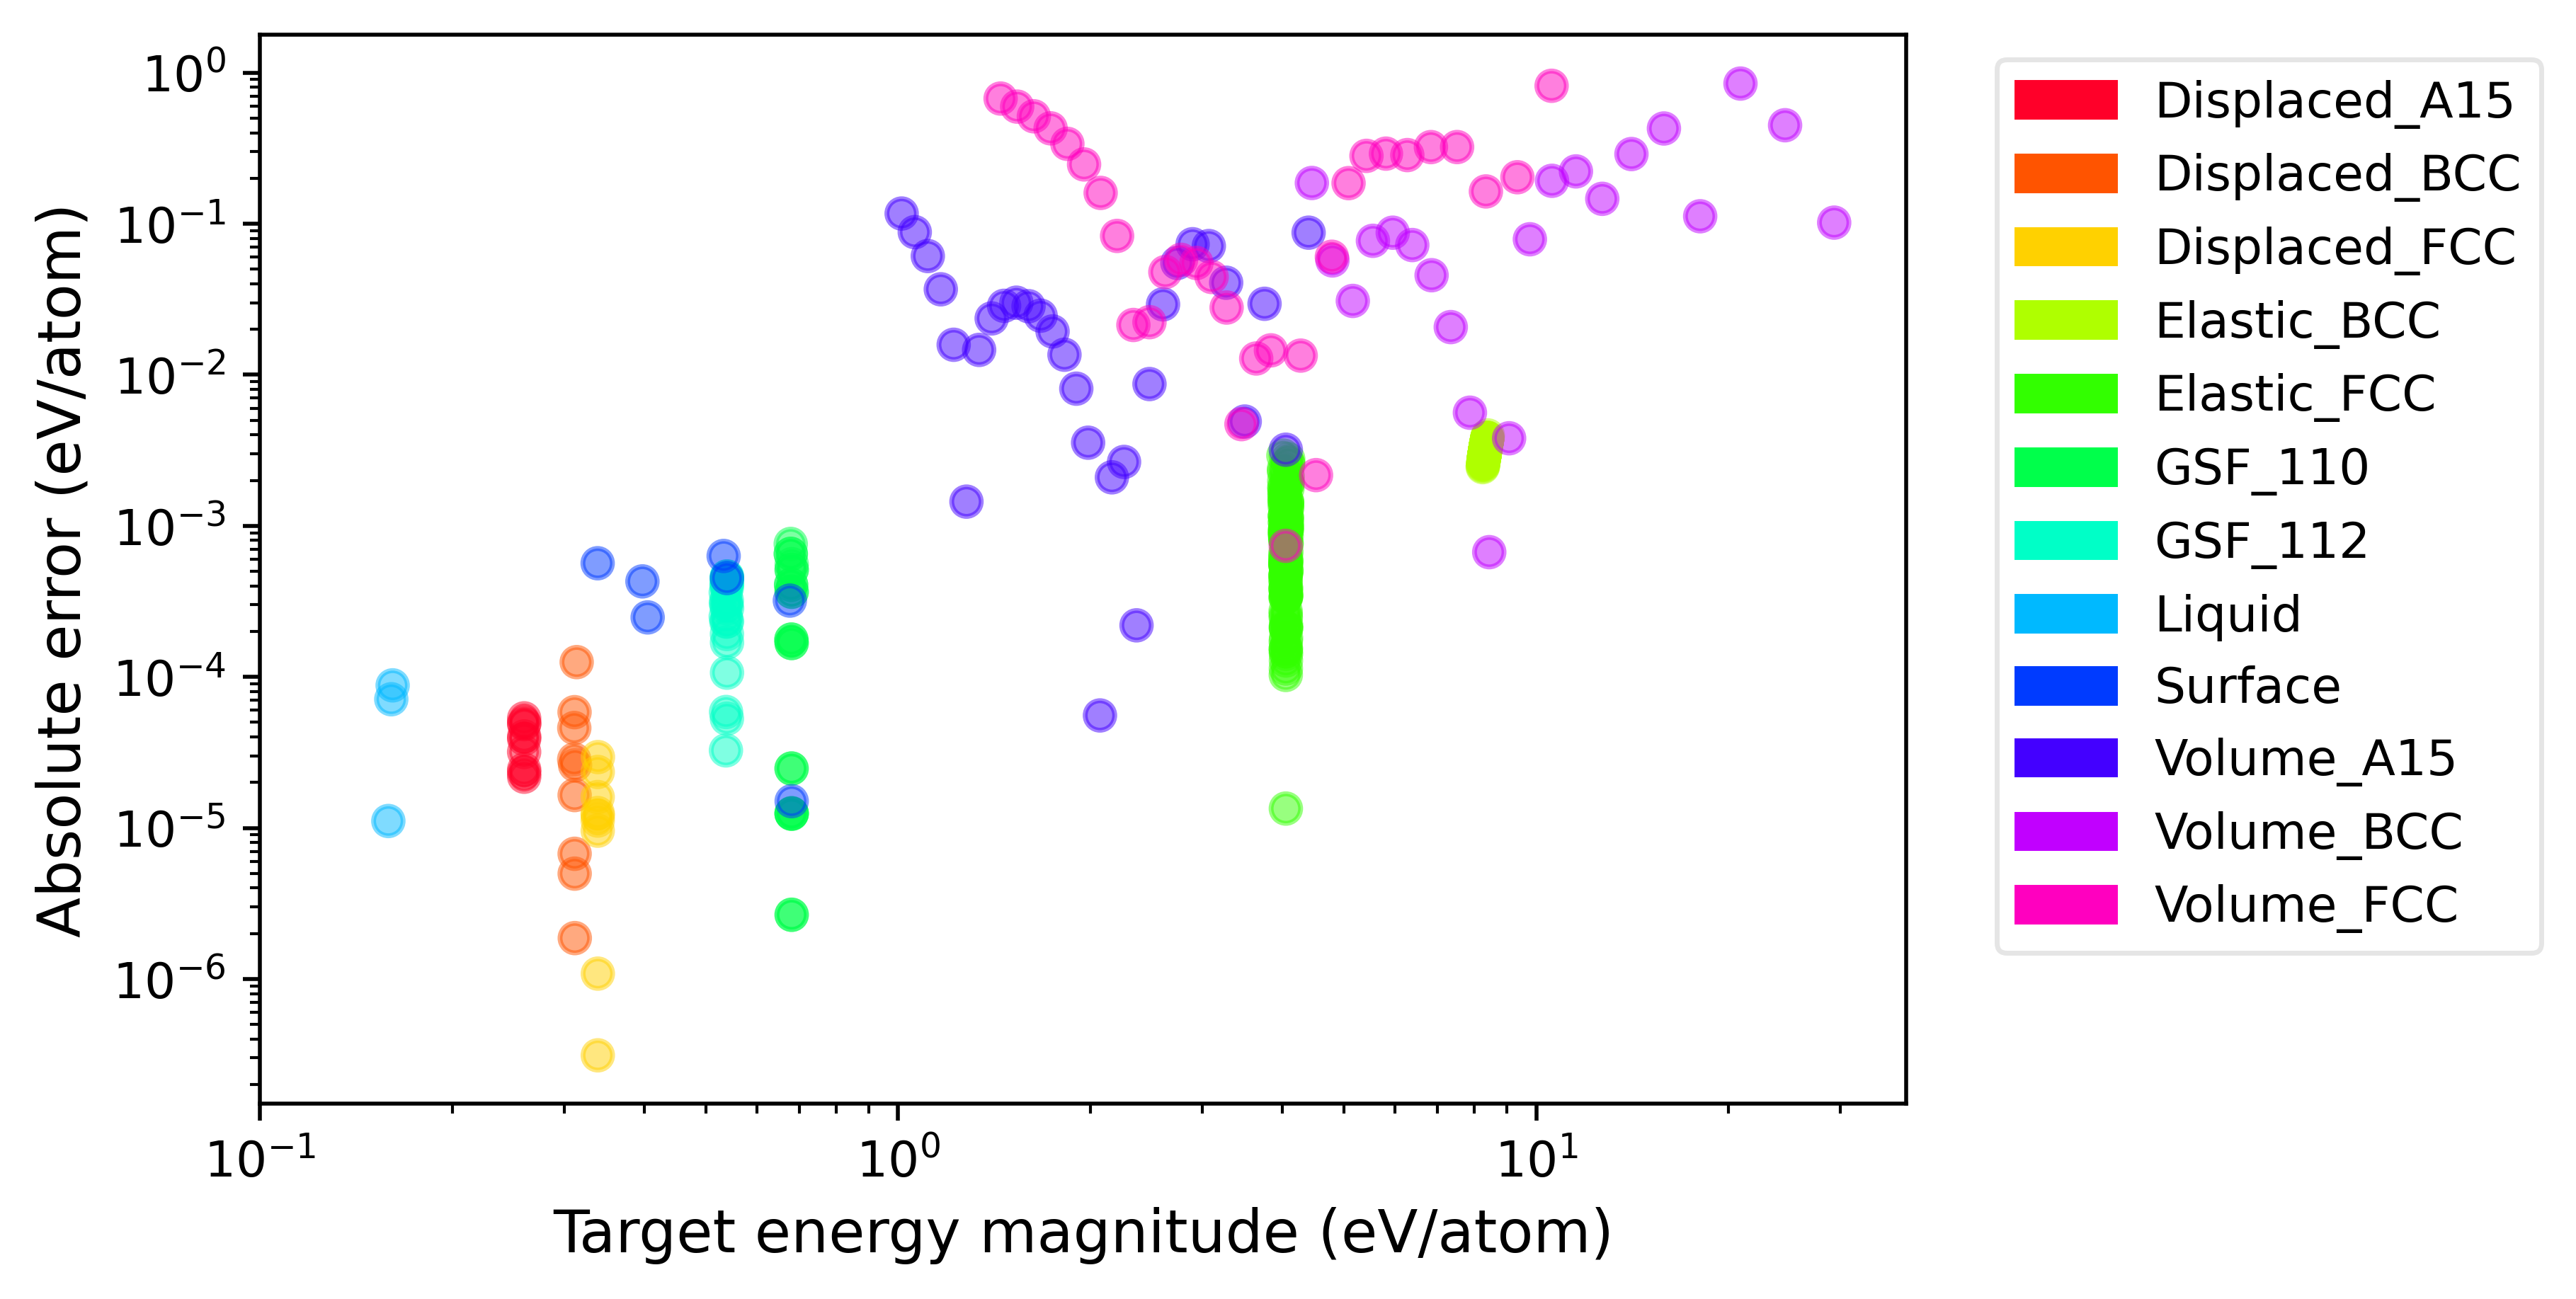

In [21]:
from IPython.display import Image
Image('energy_agreement.png')

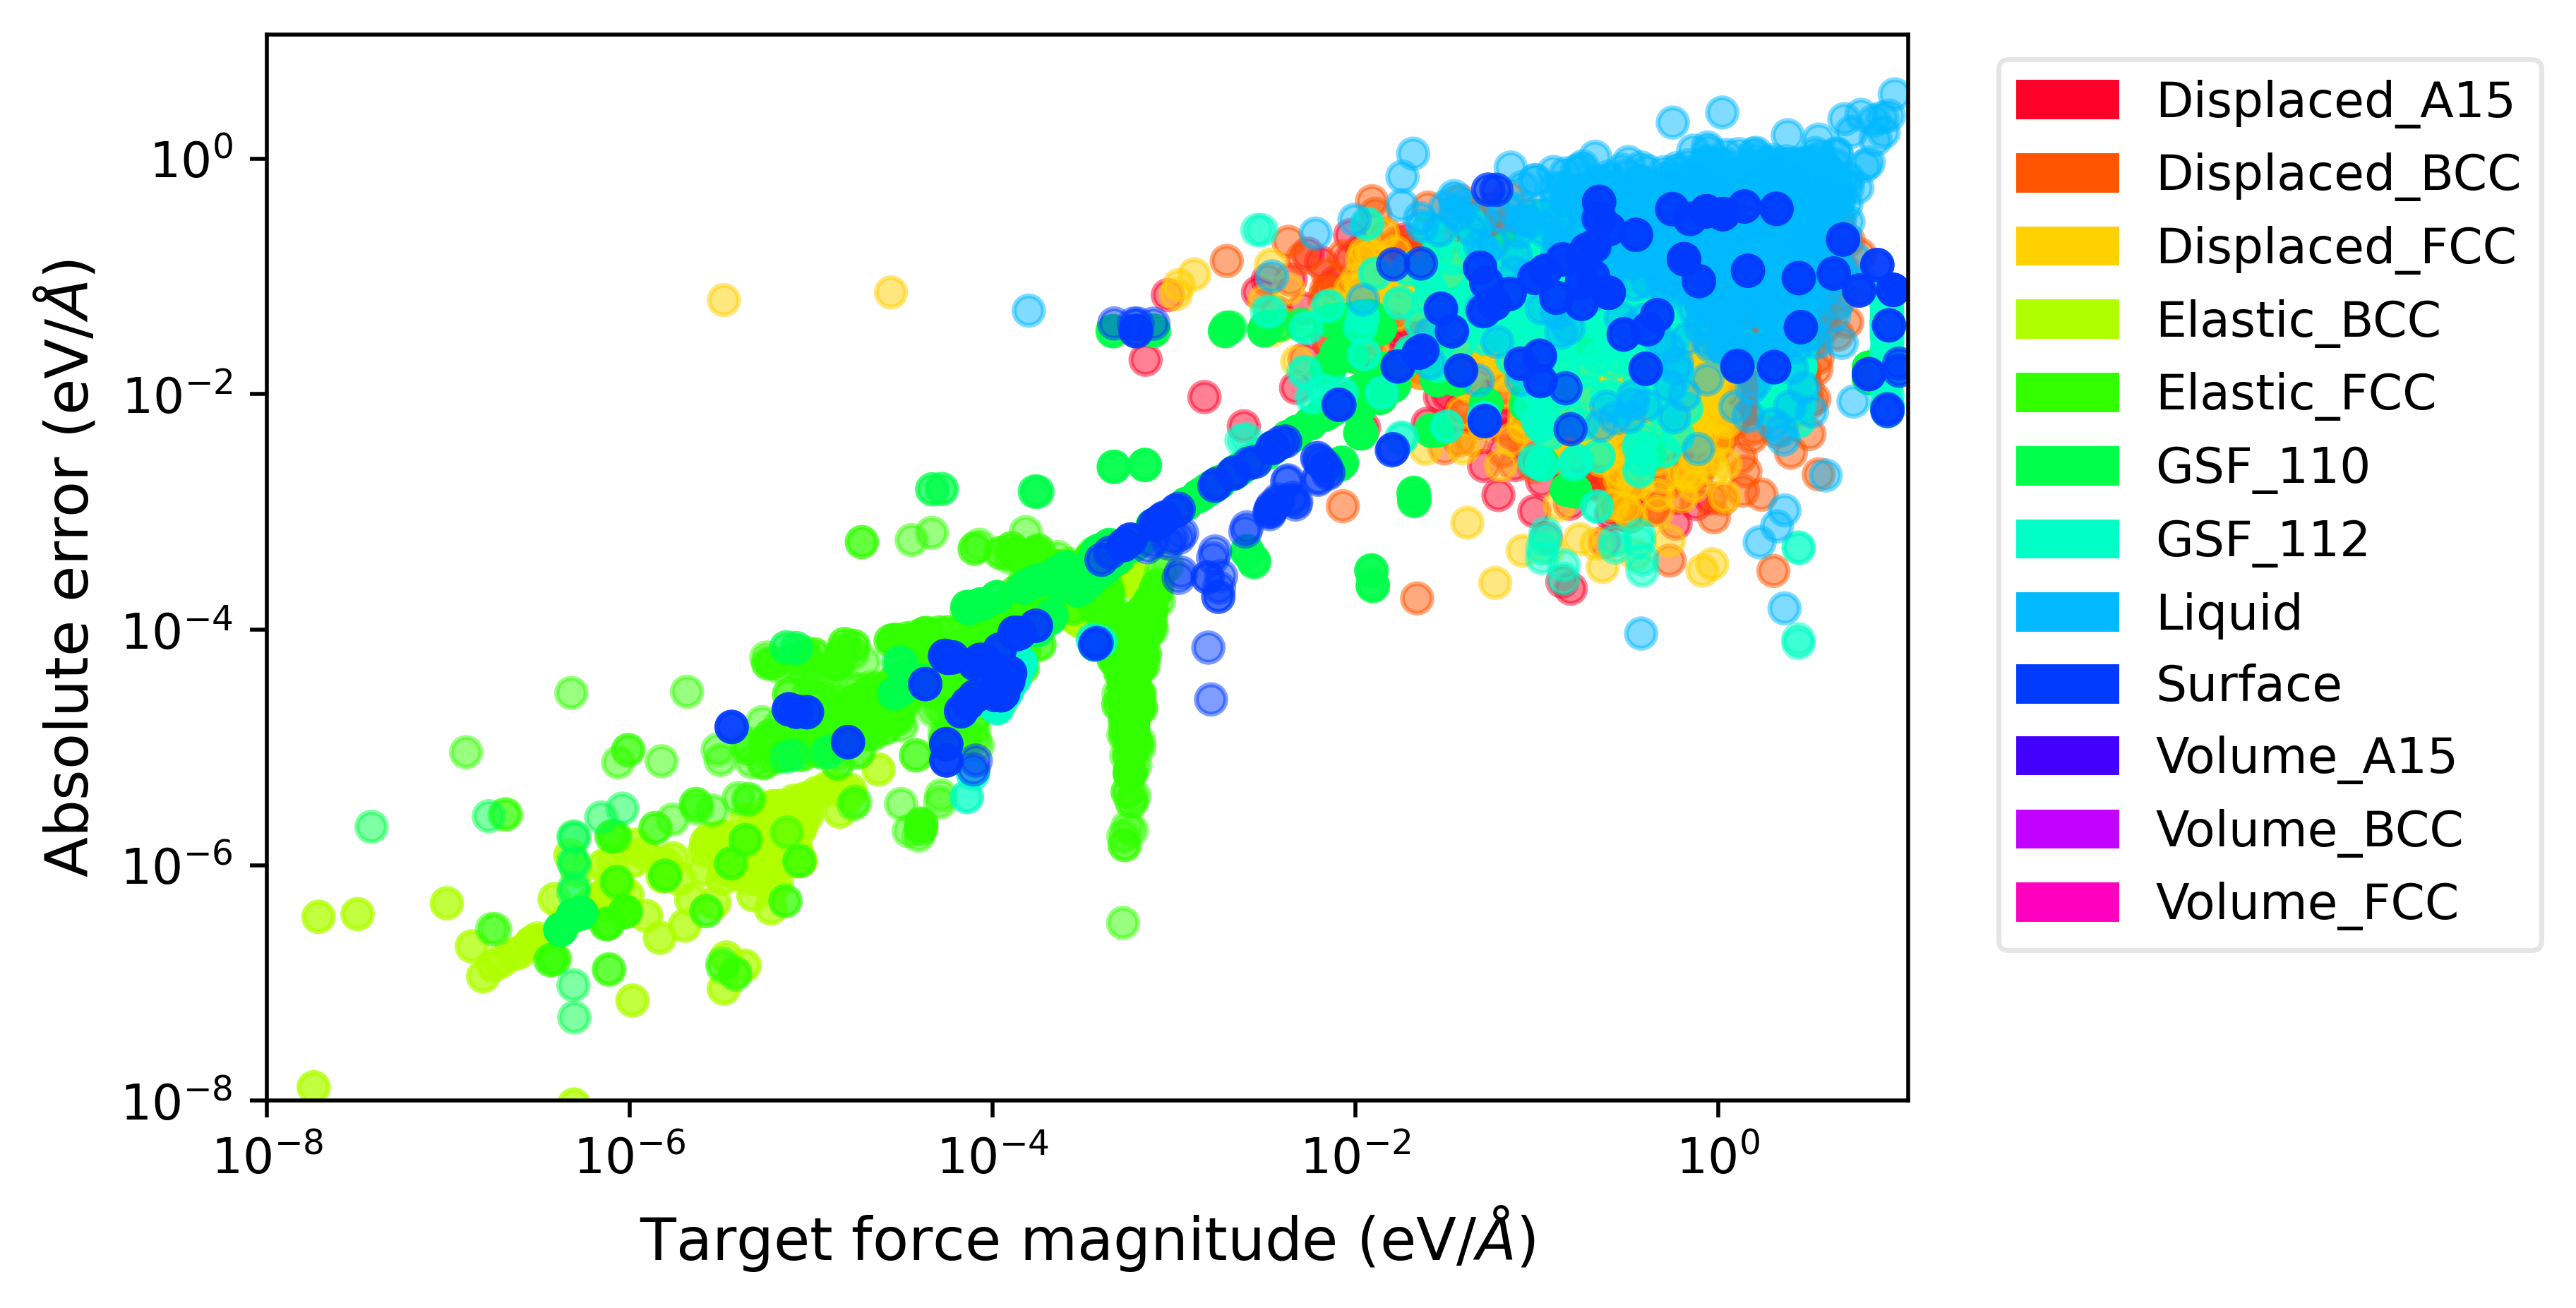

In [22]:
Image('force_agreement.png')

### Using your potential to test errors on another set.



*   When training, we calculate errors on the training set and a validation set.
*   Often it is useful to calculate errors on entirely different set (a "test set") after training.
*   We can use FitSNAP+LAMMPS Python libraries for this.
*   We will load our fitted potential into LAMMPS and calculate energies/forces, then compare to the test set.



In [23]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014/

from fitsnap3lib.tools.lammps_tools import LammpsTools

# define pair style, input script, and test directory

pairstyle = """
            pair_style hybrid/overlay zbl 4.0 4.8 snap
            pair_coeff * * zbl 73 73
            pair_coeff * * snap Ta_pot.snapcoeff Ta_pot.snapparam Ta
            """
input_script = "Ta-example.in"
test_dir = "Test_Set_Example"

lmp_tools = LammpsTools(pairstyle, input_script, test_dir)
errors = lmp_tools.calculate() # creates dictionary of errors

print(f"{'Group':20} {'Energy MAE':3} {'Force MAE':3}")
for group in errors:
    print(f"{group:20} {errors[group]['mae_energy']:.3e} {errors[group]['mae_force']:.3e}")

/content/FitSNAP/examples/Ta_Linear_JCP2014
Using LAMMPSSNAP as FitSNAP calculator
Elastic_FCC_Test : Detected  100  fitting on  100  testing on  0
Displaced_FCC_Test : Detected  9  fitting on  9  testing on  0
'decorated_scrape_configs' took 139.15 ms on rank 0
Group                Energy MAE Force MAE
Displaced_FCC_Test   2.960e-02 5.741e-02
Elastic_FCC_Test     1.447e-02 9.642e-05


Visualize force agreement on this test set

In [ ]:
# plot truth vs. pred

The FitSNAP library does more than just process fitting data...

### Perform fit in library mode

This is useful if you want to immediately screen for stability, for example when looping over fits. 

In [24]:
from fitsnap3lib.parallel_tools import ParallelTools
from fitsnap3lib.io.input import Config
pt = ParallelTools()
config = Config(arguments_lst = ["Ta-example.in", "--overwrite"])

# create a fitsnap object

from fitsnap3lib.fitsnap import FitSnap
snap = FitSnap()

# scrape configs, process configs, and perform the fit

snap.scrape_configs()
snap.process_configs()
snap.perform_fit()

#print(snap.solver.df)

Using LAMMPSSNAP as FitSNAP calculator
Displaced_A15 : Detected  9  fitting on  9  testing on  0
Displaced_BCC : Detected  9  fitting on  9  testing on  0
Displaced_FCC : Detected  9  fitting on  9  testing on  0
Elastic_BCC : Detected  100  fitting on  100  testing on  0
Elastic_FCC : Detected  100  fitting on  100  testing on  0
GSF_110 : Detected  22  fitting on  22  testing on  0
GSF_112 : Detected  22  fitting on  22  testing on  0
Liquid : Detected  3  fitting on  3  testing on  0
Surface : Detected  7  fitting on  7  testing on  0
Volume_A15 : Detected  30  fitting on  30  testing on  0
Volume_BCC : Detected  21  fitting on  21  testing on  0
Volume_FCC : Detected  31  fitting on  31  testing on  0
'decorated_scrape_configs' took 584.19 ms on rank 0
>>> Matrix of descriptors takes up  0.0277 % of the total memory: 13.6164 GB
'decorated_process_configs' took 3895.38 ms on rank 0
'decorated_perform_fit' took 613.71 ms on rank 0


This creates LAMMPS-ready potential files.

###Run MD in the same python script!

Use our LAMMPS-ready potential files immediately for MD.

In [25]:
# run MD

import lammps
lmp = lammps.lammps()

lammps_commands=\
"""
# initialize simulation

variable nsteps index 100
variable nrep equal 4
variable a equal 3.316
units           metal

# generate the box and atom positions using a BCC lattice

variable nx equal ${nrep}
variable ny equal ${nrep}
variable nz equal ${nrep}
boundary        p p p
lattice         bcc $a
region          box block 0 ${nx} 0 ${ny} 0 ${nz}
create_box      1 box
create_atoms    1 box
mass 1 180.88

# choose potential

pair_style hybrid/overlay zbl 4.0 4.8 snap
pair_coeff * * zbl 73 73
pair_coeff * * snap Ta_pot.snapcoeff Ta_pot.snapparam Ta

# setup output

thermo 100
thermo_style    custom step etotal temp pe
compute PE all pe

# set up NVE run

timestep 0.5e-3
neighbor 1.0 bin
neigh_modify once no every 1 delay 0 check yes

# run MD
velocity all create 300.0 4928459 loop geom
fix 1 all nve
run             ${nsteps}
"""

lmp.commands_string(lammps_commands)

# observe energy over a 0.5 ps period

for i in range(10):
    pe = lmp.numpy.extract_compute("PE", 0, 0)
    print(pe)
    lmp.command("run 100")

-1513.3478867568535
-1514.063191127882
-1515.1630477672247
-1514.6343606546457
-1514.2854786455205
-1514.6391693802411
-1514.7228036399665
-1514.5339732369303
-1514.4168754756142
-1514.715541433911


We also have access to the dataframe in Python:

### FitSNAP object stores dataframe as Python variable

In [26]:
snap.solver.df

,0,1,2,3,4,5,6,7,8,9,...,30,truths,preds,weights,Groups,Configs,Row_Type,Atom_I,Testing,Atom_Type
0,1.0,1.009033e+02,2.780691e+00,0.635714,8.179305e+00,-2.940313,1.045951,1.264225e+00,6.488682e+01,-2.653318e+00,...,18.753597,-16.595362,-1.659676e+01,1.000000e+02,Displaced_A15,A15_3.json,Energy,0,False,0
1,0.0,4.627919e+00,8.129999e-01,-0.232867,1.287718e+00,-0.139467,0.035210,6.649557e-02,-3.313145e+00,2.725776e-01,...,-3.676965,-0.300870,-4.361515e-01,1.000000e+00,Displaced_A15,A15_3.json,Force,0,False,1
2,0.0,-7.121813e-01,6.199341e-01,-0.837443,2.850890e+00,0.963122,-0.443889,8.972694e-01,-1.814308e+01,2.669129e+00,...,-4.574918,-0.802728,-6.584778e-01,1.000000e+00,Displaced_A15,A15_3.json,Force,0,False,1
3,0.0,-1.093067e+00,-7.484353e-01,0.144245,1.758252e+00,0.033253,0.452872,2.874145e-01,-6.299933e+00,-1.015037e+00,...,1.244826,0.046724,1.908140e-01,1.000000e+00,Displaced_A15,A15_3.json,Force,0,False,1
4,0.0,-2.880540e+00,-4.767350e-01,0.815266,-5.128569e+00,-0.935406,-0.141302,-1.044284e+00,2.733340e+01,-2.519177e+00,...,6.774157,0.909071,9.077672e-01,1.000000e+00,Displaced_A15,A15_3.json,Force,1,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15208,0.0,1.009043e+06,-1.400173e+05,-190120.257627,1.255084e+06,-258886.737857,686570.429085,1.045321e+05,2.639749e+05,-3.035289e+05,...,-789841.810903,-331591.046038,-7.783657e+04,1.000000e-09,Volume_FCC,FCC_5.5.json,Stress,0,False,0
15209,0.0,1.009043e+06,-1.400173e+05,-190120.257627,1.255084e+06,-258886.737857,686570.429085,1.045321e+05,2.639749e+05,-3.035289e+05,...,-789841.810903,-331591.046038,-7.783657e+04,1.000000e-09,Volume_FCC,FCC_5.5.json,Stress,0,False,0
15210,0.0,0.000000e+00,0.000000e+00,0.000000,-3.421232e-11,0.000000,0.000000,0.000000e+00,7.483945e-12,-1.282962e-11,...,0.000000,0.000000,3.627234e-12,1.000000e-09,Volume_FCC,FCC_5.5.json,Stress,0,False,0
15211,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,1.282962e-11,-4.276540e-12,...,0.000000,0.000000,-3.446098e-12,1.000000e-09,Volume_FCC,FCC_5.5.json,Stress,0,False,0


*We can perform fits in Python scripts, run MD to check for stability, and still have access to the detailed errors in the dataframe.*

This provies a lot of flexibility/possibilities for various training methods.

For example, one could loop over many fits while tweaking hyper-parameters.

### Loop over fits


*   This can be done to optimize hyperparameters for example.
*   Look at the `config` object to understand how we change settings for each fit. 
*   `config` contains information on the sections defined in the input script.
*   Examples:
*   `config.sections['BISPECTRUM']` contains bispectrum/descriptor settings.
*   `config.sections['GROUPS'].group_table['Liquid']['eweight']` contains energy weights associated with the `Liquid` group.
*   etc...
*   See more on Config files at https://docs.python.org/3/library/configparser.html

Define functions that we'll use for looping over fits:

In [27]:
import numpy as np

def change_descriptor_hyperparams(config):

    # twojmax, wj, and radelem are lists of chars

    config.sections['BISPECTRUM'].twojmax = ['6']
    config.sections['BISPECTRUM'].wj = ['1.0']
    config.sections['BISPECTRUM'].radelem = ['0.5']

    # rcutfac and rfac0 are doubles

    config.sections['BISPECTRUM'].rcutfac = 4.67637
    config.sections['BISPECTRUM'].rfac0 = 0.99363

    # after changing twojmax, need to generate_b_list to adjust all other variables

    config.sections['BISPECTRUM']._generate_b_list()

    return config

def change_weights(config, data):
    """
    Change fitting weights associated with each configuration of atoms.

    Attributes
    ----------

    config: FitSNAP Config object
        Holds input setting data

    data: FitSNAP data object
        Holds configuration data, positions, forces, weights, etc.
    """

    # need to find out how many groups there are

    ngroups = len(config.sections['GROUPS'].group_table)
    nweights = 0

    # loop through all group weights in the group_table and change the value

    for key in config.sections['GROUPS'].group_table:
        for subkey in config.sections['GROUPS'].group_table[key]:
            if ("weight" in subkey):
                nweights += 1
                # change the weight
                config.sections['GROUPS'].group_table[key][subkey] = np.random.rand(1)[0]

    # loop through all configurations and set a new weight based on the group table

    for i, configuration in enumerate(data):
        group_name = configuration['Group']
        new_weight = config.sections['GROUPS'].group_table[group_name]
        for key in config.sections['GROUPS'].group_table[group_name]:
            if ("weight" in key):
                # set new weight 
                configuration[key] = config.sections['GROUPS'].group_table[group_name][key]

    return(config, data)

Use these functions to loop over fits while changing descriptors settings and/or weights:

In [28]:
from fitsnap3lib.tools.dataframe_tools import DataframeTools
from fitsnap3lib.parallel_tools import ParallelTools
from fitsnap3lib.io.input import Config
pt = ParallelTools()
config = Config(arguments_lst = ["Ta-example.in", "--overwrite"])

# create FitSNAP object
from fitsnap3lib.fitsnap import FitSnap
snap = FitSnap()

ngenerations = 2
for g in range(0,ngenerations):

    del snap
    del config
    del pt

    pt = ParallelTools()
    config = Config(arguments_lst = ["Ta-example.in", "--overwrite"])
    snap = FitSnap()

    # tell ParallelTool not to create SharedArrays
    #pt.create_shared_bool = False
    # tell ParallelTools not to check for existing fitsnap objects
    #pt.check_fitsnap_exist = False
    # tell FitSNAP not to delete the data object after processing configs
    snap.delete_data = True
    snap.scraper.scrape_groups()
    snap.scraper.divvy_up_configs()
    snap.data = snap.scraper.scrape_configs()

    # change the bispectrum hyperparams

    config = change_descriptor_hyperparams(config)

    # change weight hyperparams

    (config, snap.data) = change_weights(config, snap.data)
    
    # process configs with new hyperparams
    # set indices to zero for populating new data array

    snap.calculator.shared_index=0
    snap.calculator.distributed_index=0 
    snap.process_configs()
     
    # perform a fit and gather dataframe with snap.solver.error_analysis()

    snap.solver.perform_fit()
    snap.solver.fit_gather()
    # need to empty errors before doing error analysis
    snap.solver.errors = []
    snap.solver.error_analysis()

    # now we have the dataframe, calculate errors with it

    df_tool = DataframeTools(snap.solver.df)
    mae_energy = df_tool.calc_error("Energy", "Training")
    mae_force = df_tool.calc_error("Force", "Training")

    print(f"---------- Generation {g} Force MAE: {mae_force} Energy MAE: {mae_energy}")

Using LAMMPSSNAP as FitSNAP calculator
Using LAMMPSSNAP as FitSNAP calculator
Displaced_A15 : Detected  9  fitting on  9  testing on  0
Displaced_BCC : Detected  9  fitting on  9  testing on  0
Displaced_FCC : Detected  9  fitting on  9  testing on  0
Elastic_BCC : Detected  100  fitting on  100  testing on  0
Elastic_FCC : Detected  100  fitting on  100  testing on  0
GSF_110 : Detected  22  fitting on  22  testing on  0
GSF_112 : Detected  22  fitting on  22  testing on  0
Liquid : Detected  3  fitting on  3  testing on  0
Surface : Detected  7  fitting on  7  testing on  0
Volume_A15 : Detected  30  fitting on  30  testing on  0
Volume_BCC : Detected  21  fitting on  21  testing on  0
Volume_FCC : Detected  31  fitting on  31  testing on  0
>>> Matrix of descriptors takes up  0.0277 % of the total memory: 13.6164 GB
'decorated_process_configs' took 3192.59 ms on rank 0
---------- Generation 0 Force MAE: 0.2720192668774736 Energy MAE: 0.06572811036948685
Using LAMMPSSNAP as FitSNAP c

Can get creative here:

*   Run MD each iteration and train for stability, or some other property.
*   Optimize against some other external validation set, chosen by whatever means.
*   Any optimization approach can be wrapped around this framework.

*These capabilities demonstrate the flexibility of fitting we can have, but what about analyzing the data that we fit to?*

### Extracting per-atom SNAP descriptors

This is useful if you want to inspect the phase space of your descriptors, do PCA analysis, etc.

Make the following changes to the input script: 

*   `bikflag = 1` in `[BISPECTRUM]`
*   `bzeroflag = 1` in `[BISPECTRUM]` (required by `per_atom_energy = 1`)
*   `per_atom_energy = 1` in `[CALCULATOR]`

Calculate per-atom descriptors without performing a fit:

In [46]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014 
!python -m fitsnap3 Ta-example.in --overwrite --nofit

/content/FitSNAP/examples/Ta_Linear_JCP2014

    ______ _  __  _____  _   __ ___     ____  
   / ____/(_)/ /_/ ___/ / | / //   |   / __ \ 
  / /_   / // __/\__ \ /  |/ // /| |  / /_/ /
 / __/  / // /_ ___/ // /|  // ___ | / ____/ 
/_/    /_/ \__//____//_/ |_//_/  |_|/_/      

-----23Sep22------
Reading input...
Finished reading input
------------------
mpi4py version:  3.1.3
numpy version:  1.21.6
scipy version:  1.7.3
pandas version:  1.3.5
LAMMPS (15 Sep 2022)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
-----------
Total wall time: 0:00:00
Using LAMMPSSNAP as FitSNAP calculator
Displaced_A15 : Detected  9  fitting on  9  testing on  0
Displaced_BCC : Detected  9  fitting on  9  testing on  0
Displaced_FCC : Detected  9  fitting on  9  testing on  0
Elastic_BCC : Detected  100  fitting on  100  testing on  0
Elastic_FCC : Detected  100  fitting on  100  testing on  0
GSF_110 : Detected  22  fitting on  22  

Now our dataframe contains per-atom descriptors. 



In [49]:
!python --version

Python 3.7.14


In [47]:
from fitsnap3lib.tools.dataframe_tools import DataframeTools
df_tool = DataframeTools("FitSNAP.df")
df = df_tool.read_dataframe()
df_tool.plot_tsne(num_descriptors = 30, point_size=0.2)

AttributeError: ignored

We also need per-atom descriptors for NN potentials, which we will do next.

# Fit NN-SNAP for tantalum

In [ ]:
%cd /content/FitSNAP/examples/Ta_PyTorch_NN

/content/FitSNAP/examples/Ta_PyTorch_NN


In [ ]:
!python -m fitsnap3 Ta-example.in --overwrite

CALCULATOR IO ----------
----- Global weights set: Overriding group weights.
----- Global training fraction set: Overriding group fractions.

    ______ _  __  _____  _   __ ___     ____  
   / ____/(_)/ /_/ ___/ / | / //   |   / __ \ 
  / /_   / // __/\__ \ /  |/ // /| |  / /_/ /
 / __/  / // /_ ___/ // /|  // ___ | / ____/ 
/_/    /_/ \__//____//_/ |_//_/  |_|/_/      

-----23Sep22------
Reading input...
Finished reading input
------------------
mpi4py version:  3.1.3
numpy version:  1.21.6
scipy version:  1.7.3
pandas version:  1.3.5
LAMMPS (15 Sep 2022)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
-----------
Total wall time: 0:00:00
Using LAMMPSSNAP as FitSNAP calculator
/usr/local/lib/python3.7/dist-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set a

### Run MD

In [ ]:
%cd /content/FitSNAP/examples/Ta_PyTorch_NN/MD

/content/FitSNAP/examples/Ta_PyTorch_NN/MD


In [ ]:
!/content/lammps/build/lmp < in.run

LAMMPS (15 Sep 2022)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 3.316 3.316 3.316
Created orthogonal box = (0 0 0) to (13.264 13.264 13.264)
  1 by 1 by 1 MPI processor grid
Created 128 atoms
  using lattice units in orthogonal box = (0 0 0) to (13.264 13.264 13.264)
  create_atoms CPU = 0.000 seconds
Loading python model complete.
SNAP keyword rcutfac 4.67637 
SNAP keyword twojmax 6 
SNAP keyword nelems 1 
SNAP keyword elems Ta 
SNAP keyword radelems 0.5 
SNAP keyword welems 1 
SNAP keyword rfac0 0.99363 
SNAP keyword rmin0 0 
SNAP keyword bzeroflag 1 
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 5.8
  ghost atom cutoff = 5.8
  binsize = 2.9, bins = 5 5 5
  2 neighbor lists, perpetual/occasional/extra = 2 0 0
  (1) pair zbl, perpetual
      attributes: half, newton on
  

KeyboardInterrupt: ignored

# Fit NN potential for iron

In [ ]:
%cd /content/FitSNAP/examples/Fe_Pytorch_NN

/content/FitSNAP/examples/Fe_Pytorch_NN


In [ ]:
!python -m fitsnap3 Fe-example.in --overwrite

CALCULATOR IO ----------
----- Global weights set: Overriding group weights.
----- Global training fraction set: Overriding group fractions.

    ______ _  __  _____  _   __ ___     ____  
   / ____/(_)/ /_/ ___/ / | / //   |   / __ \ 
  / /_   / // __/\__ \ /  |/ // /| |  / /_/ /
 / __/  / // /_ ___/ // /|  // ___ | / ____/ 
/_/    /_/ \__//____//_/ |_//_/  |_|/_/      

-----23Sep22------
Reading input...
Finished reading input
------------------
mpi4py version:  3.1.3
numpy version:  1.21.6
scipy version:  1.7.3
pandas version:  1.3.5
LAMMPS (15 Sep 2022)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
-----------
Total wall time: 0:00:00
Using LAMMPSSNAP as FitSNAP calculator
/usr/local/lib/python3.7/dist-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set a

In [ ]:
!lsmod | grep nvidia

nvidia_drm             16384  0
nvidia_uvm            974848  2
nvidia              33898496  31 nvidia_uvm


In [ ]:
!rmmod nvidia_drm
!rmmod nvidia_uvm
!rmmod nvidia_modeset

rmmod: ERROR: ../libkmod/libkmod-module.c:793 kmod_module_remove_module() could not remove 'nvidia_drm': Operation not permitted
rmmod: ERROR: could not remove module nvidia_drm: Operation not permitted
rmmod: ERROR: Module nvidia_uvm is in use
rmmod: ERROR: Module nvidia_modeset is not currently loaded


In [ ]:
!nvidia-smi

Failed to initialize NVML: Driver/library version mismatch


In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
cuda0 = torch.device('cuda:0')
a = torch.ones(3, 2, device=cuda0) #creating a tensor 'a' on GPU
print(a)

1
Tesla T4
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], device='cuda:0')


#Custom calculator

Show how we can extract pure LAMMPS positions and neighlist

This allows one to define their own descriptor and Solver using these positions.

Show library mode plot of descriptors.

# End-to-End Differentiable Potentials